# Project: Investigate a Dataset
### Data Analyst Nanodegree

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>




<a id='intro'>  </a>
## Introduction
In this report we are going to perform a quick investigation on a dataset that contains more than 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment.
For this analysis we are going to use external libraries such as pandas, numpy and matplotlib in order to optimize the process.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv') # df will be the name of this main dataframe

We are going to try to answer the following questions: 
<ul><li>Are patients of one gender more absent than of the other? </li>
    <li>Do some hospitals get more patients not showing up for their appoinment?</li>
    <li>Is the age of patients a factor when measuring absenteeism?</li>
    <li>Does the time between citation and appointment increase or decrease absenteeism?</li>
<li>Is it likely that a patient who has not shown up once does not go to the next appointment?</li></ul>

### First look at our data

In [3]:
df.shape

(110527, 14)

In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Our data is a decently large, consisting in over 110k entries with 14 columns each. Any of the columns contains null values.

### Some name changing

First of all, I am changing the column name system, that feels a little bit inconsistent, with snake case style ones, also im going to shorten some of them for preventing typing errors.

In [5]:
df.columns = [x.lower() for x in df.columns] # Iterates over the column names and applies lower()

In [6]:
new_names = {'patientid' : 'patient_id', 'scheduledday' : 's_day', 'appointmentday' : 'a_day', 'no-show' : 'no_show'}
df.rename(columns = new_names, inplace = True) # I manually changed the rest of names

In [7]:
df.drop(columns = ['appointmentid', 'alcoholism', 'scholarship', 'hipertension', 'diabetes', 'handcap', 'sms_received'], inplace = True) 
                                                    # The appointment Id is unique for each column and does not 
                                                    # provide any useful information for this analysis, so we drop it, as well 
                                                    # all the colums we are not going to look into

<a id='wrangling'></a>
## Data Wrangling and cleaning



We need to get rid of duplicated rows and deal with nulls before we can continue

In [8]:
df.duplicated().sum() # No duplicated rows

1305

The s_day and a_day columns are still not formatted as a proper pandas datetime date, just as a string, so we change that, and just keep the date because the time is missing in a_date, so time comparisons could by misleading.

In [9]:
df['s_day'] = pd.to_datetime(df['s_day'] ).dt.date
df['a_day'] = pd.to_datetime(df['a_day'] ).dt.date

What about the age?

In [10]:
df.age.sort_values().head(1) # Negative value in age? Drop it!

99832   -1
Name: age, dtype: int64

In [11]:
df.drop(index = 99832, inplace = True)

One of the questions we are addresing is the time passed between the citation and appointment day. We are going to create a new column for the dataframe, called time_passed, to keep track of days passed in a single integer.

In [12]:
df['days_passed'] = df['a_day'] - df['s_day'] # New column added
df.sort_values('days_passed', inplace = True) # Then we sort them by days passed
df.days_passed = df.days_passed.dt.days.astype('int') # And it as numbers instead of datetimes

In [13]:
df.days_passed.head(10)

71533   -6
72362   -1
64175   -1
55226   -1
27033   -1
57785    0
57786    0
57787    0
57788    0
57789    0
Name: days_passed, dtype: int32

In [14]:
df = df.sort_values('days_passed')[5:] # No negative differences between days

Finally we change the no_show column to contain nice ones a zeros instead of the yes or no strings. We achieve it with a one liner:

In [15]:
df.no_show = df.no_show.eq('Yes').mul(1)

And here is our new dataset, ready to answer just the right questions:

In [16]:
df.head() # Let's take a look to the final dataset   

,patient_id,gender,s_day,a_day,age,neighbourhood,no_show,days_passed
85706,2.228872e+11,F,2016-06-08,2016-06-08,84,CARATOÍRA,0,0
85825,2.158213e+10,F,2016-06-01,2016-06-01,30,JARDIM CAMBURI,0,0
85709,3.352947e+13,M,2016-06-08,2016-06-08,49,ARIOVALDO FAVALESSA,0,0
85712,7.456526e+12,M,2016-06-08,2016-06-08,49,ARIOVALDO FAVALESSA,0,0
85787,7.647816e+13,F,2016-06-01,2016-06-01,60,JARDIM CAMBURI,0,0


<a id='eda'></a>
## Exploratory Data Analysis

Now we are going to use this dataset to perform a quick analysis in order to answer a few questions. The goal of this exercise is getting confidence in Python as data analysis tool and get hands on into real world data.

#### Some variable setting

In [17]:
total_pa = df.patient_id.nunique() # Number of total patients
total_ap = df.no_show.count() #      Number of total appointments, counting a randomly chose variable
total_ap_ns = df.no_show.sum() #     Number of appointments with the patient not showing up

### Does gender matters in patients not showing?

In [18]:
total_f = df.query('gender == "F"').patient_id.nunique() #    Number of total female patients, we only count unique patients
total_m = df.query('gender == "M"').patient_id.nunique() #    Number of total male patients
total_f_ns = df.query('gender == "F" and no_show == 1').patient_id.nunique() # Females that didn't show up at least 1 time
total_m_ns = df.query('gender == "M" and no_show == 1').patient_id.nunique() # Males that didn't show up at least 1 time

In [19]:
print('Total number of males: {} \nTotal number of females: {}\nTotal number of males not showing up: {} \nTotal number of females not showing up: {}'.format(total_m, total_f, total_m_ns, total_f_ns))

Total number of males: 22253 
Total number of females: 40045
Total number of males not showing up: 6155 
Total number of females not showing up: 11506


In [20]:
ns_m_r = total_m_ns / total_m * 100
ns_f_r = total_f_ns / total_f * 100
print('Not showing males ratio: {}%\nNot showing females ratio: {}%'.format(int(ns_m_r), int(ns_f_r)))

Not showing males ratio: 27%
Not showing females ratio: 28%


The ratio of absentism does not vary much from one gender to another. The female absentism is a little bit higher, but also the number of female records nearly doubles males, so it isn't clear. Lets take a look at it with a bar graph:

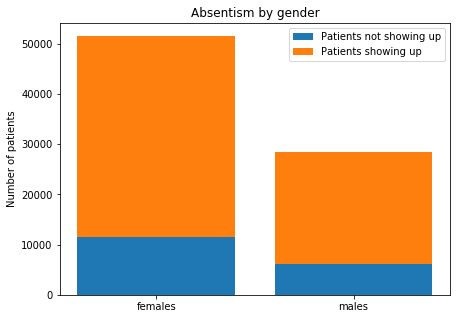

In [21]:
plt.figure(figsize = (7,5))
p_ns = plt.bar(['females', 'males'], [total_f_ns, total_m_ns])
p_s = plt.bar(range(2), [total_f, total_m], bottom = [total_f_ns, total_m_ns])
plt.title('Absentism by gender')
plt.ylabel('Number of patients')
plt.legend((p_ns[0], p_s[0]),('Patients not showing up', 'Patients showing up'));

### Have some hospitals more absentism ratio than others?

The neighbourhood column indicates the hospital where the appoinment took place, we are going to take a look at the number of patients that have records in each hospital and the ones that didn't show up.

In [22]:
ne_total = df.groupby(['patient_id', 'neighbourhood'], as_index = False).count().neighbourhood.value_counts() 
ne_ns = df.query('no_show >= 1').groupby(['patient_id', 'neighbourhood'], as_index = False).count().neighbourhood.value_counts()

Now that we have our series, we create a new one, containing the correspondent ratios.

In [23]:
r_neigh = ne_ns / ne_total * 100

In [24]:
r_neigh.sort_values(ascending = False).head(7)

ILHAS OCEÂNICAS DE TRINDADE    100.000000
SANTOS DUMONT                   40.225035
ILHA DO FRADE                   40.000000
SANTA CECÍLIA                   39.506173
HORTO                           38.613861
JESUS DE NAZARETH               37.325905
SANTA CLARA                     36.231884
Name: neighbourhood, dtype: float64

These are the 7 hospitals with the highest no show ratio, we can omit some of them, like the one corresponding to Ilhas Oceanicas de Trindade, beacuse of the lack of records, with only 2, as seen here:

In [25]:
ne_total['ILHAS OCEÂNICAS DE TRINDADE']

2

In [26]:
r_neigh.median() # Median ratio of absentism by hospital. We use the median to 
                 # avoid extreme values interference, as the one seen before

28.019073196812016

The median is about 28%. Some of the hospitals seen before have values signicantly higher, also if we sort the data from below we can also see that there are ones with lower ratios, so we can confirm patient absentism does group by hospitals in this sample.

In [27]:
r_neigh.sort_values().head(7)

ILHA DO BOI        13.636364
AEROPORTO          14.285714
DO QUADRO          20.440882
VILA RUBIM         21.787709
DO CABRAL          22.082019
JARDIM DA PENHA    22.277639
SOLON BORGES       22.302158
Name: neighbourhood, dtype: float64

### Does the age matters in patients not showing?

To answer this question, I create a new Dataframe called ages from the join of two other Dataframes (age_t, age_ns). With the ages present in the sample as the index, and two columns containg the count of all of them, and the another the count of the ages of not appeared patients. Then a create a third column with the ratio of absentism by age.

In [28]:
age_t = pd.DataFrame(df.query('no_show == 1')['age'].value_counts()).rename(columns = {'age' : 'p_age_ns'}).sort_index()
age_ns = pd.DataFrame(df['age'].value_counts()).sort_index()
# Two series converted to dataframes to allow the join

In [29]:
ages = age_ns.join(age_t).fillna(0) # Some of the ages are nos present in the p_age_ns column, so we change the nulls with zeros

In [30]:
ages['age_ratio'] = (ages.p_age_ns / ages.age * 100).astype(int) # The ratio of not showing patients by age

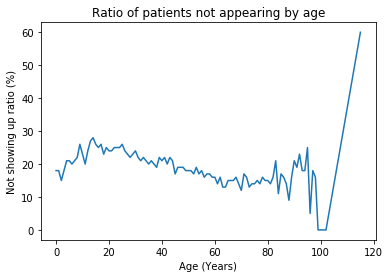

In [31]:
plt.title('Ratio of patients not appearing by age') # Time to plot!
plt.plot(ages.index, ages.age_ratio)
plt.xlabel('Age (Years)')
plt.ylabel('Not showing up ratio (%)');

That peak at the end of the Dataset is ruining our graph. Patients over the hundreds is going to have any impact on the analysis, so we plot again with the last value.

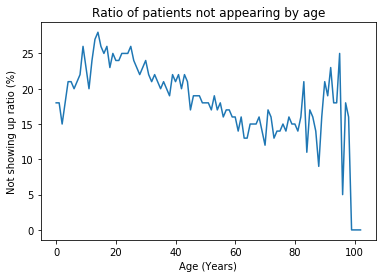

In [32]:
plt.title('Ratio of patients not appearing by age')
plt.plot(ages.index[:-1], ages.age_ratio[:-1])
plt.xlabel('Age (Years)')
plt.ylabel('Not showing up ratio (%)');

This graph shows that the ratio of patients not showing up to the appointment seems to increase with the age until it reachs 14 years old, then it begins to fall from over the 25% to the 10% until the 90s, so eldest are more apealing of not showing up.

### Does the time passed between the citation and the appointment matters in patients not showing up?

Do the appointments set too far away un time get more patients not showing? That question can be answered by the columns with the scheduled day and the appointment day. As they are already datetime type, we can operate them to get the day passed. All these operations will be performed in a copy of the Dateframe df called dfdates.

In [33]:
dfdates = df[['days_passed', 'no_show']].copy()

In [34]:
dfdates_pa = pd.DataFrame(dfdates.groupby('days_passed').count().no_show).rename(columns ={'no_show' : 'total_patients'})
 # I just saved this column for the final dataframe

In [35]:
dfdates = pd.DataFrame(dfdates.query('no_show == 1').groupby('days_passed').count().no_show).join(dfdates_pa)
# Two operations here: first I get the counts of the missing patients, then I join it with dfdates_pa

In [36]:
dfdates['no_show_ratio'] = dfdates.no_show / dfdates.total_patients * 100 # Get the ratio of patients not showing up

In [37]:
dfdates = dfdates[dfdates.total_patients > 100] # Any size of sample below 100 is not going to be kept

In [38]:
dfdates.total_patients.sort_values(ascending = False).head(2)

days_passed
0    38562
2     6725
Name: total_patients, dtype: int64

There is a large maximum at 0 day passed. Most of the patients got their appointment the same day it was scheduled, so we dont keep track of that in our plot.

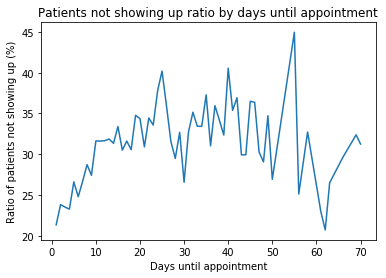

In [39]:
plt.title('Patients not showing up ratio by days until appointment')
plt.plot(dfdates.index[1:], dfdates.no_show_ratio[1:])
plt.xlabel('Days until appointment')
plt.ylabel('Ratio of patients not showing up (%)');

It is obvious that the ratio increases over the first 15 days. Starting from 22% the day after the appointment up to 40 passing 20 days, then it stays over 30 and 35 percent.

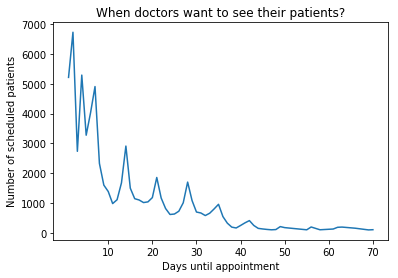

In [40]:
plt.title('When doctors want to see their patients?') #   Lets explore some additional data
plt.plot(dfdates.index[1:], dfdates.total_patients[1:]) # How do doctors set the appointment? 
plt.xlabel('Days until appointment')
plt.ylabel('Number of scheduled patients')
plt.xticks([10, 20, 30, 40, 50, 60, 70]);

And here is a interesting graph. It seems that doctors want to see their patients mostly the very same week, them the rate of patients being scheduled decreases constantly except for peaks on appoinments set for 2, 3, and 4 weeks after.

### How many patients did not show up multiple times?

In this section we are going to answer how many patients did not show up to the appointment more than once. Then we are going to look at these patients and find out which gender is more likely of not appering more than once.

In [41]:
total_pa_ns = df.groupby('patient_id').no_show.sum() 
total_pa_ns = len(total_pa_ns[total_pa_ns > 0]) # The total of patients that didnt show up

In [42]:
total_pa_ns_m = df.groupby('patient_id').no_show.sum() 
total_pa_ns_m = len(total_pa_ns_m[total_pa_ns_m > 1]) # The total of patients that din't show up for a second time or more

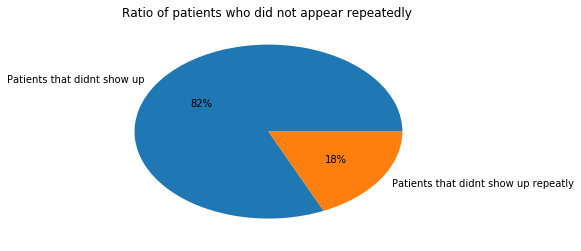

In [43]:
plt.title('Ratio of patients who did not appear repeatedly ') 
plt.pie([total_pa_ns - total_pa_ns_m, total_pa_ns_m], labels = ('Patients that didnt show up', 'Patients that didnt show up repeatly'), autopct='%.0f%%');

In [44]:
p_total_pa_ns = int(total_pa_ns / total_pa * 100) # p stands for pencentage
p_total_pa_ns_m = int(total_pa_ns_m / total_pa_ns * 100)

In [45]:
print ('The {}% of the total patients ({} total patients) did not show up at least one time ({} patients).\n{}% of these patients ({}) did not show up again at least one time.'.format(p_total_pa_ns, total_pa, total_pa_ns, p_total_pa_ns_m, total_pa_ns_m))

The 28% of the total patients (62298 total patients) did not show up at least one time (17661 patients).
18% of these patients (3223) did not show up again at least one time.


Now we can repeat the process by filtering the data by gender.

In [46]:
total_pa_ns_f = df.query('gender == "F"').groupby('patient_id').no_show.sum() 
total_pa_ns_f = len(total_pa_ns_f[total_pa_ns_f > 0]) # The total of females that didnt show up
total_pa_ns_ma = df.query('gender == "M"').groupby('patient_id').no_show.sum() 
total_pa_ns_ma = len(total_pa_ns_ma[total_pa_ns_ma > 0]) # The total of males that didnt show up

In [47]:
total_pa_ns_m_f = df.groupby('patient_id').no_show.sum() 
total_pa_ns_m_f = len(total_pa_ns_m_f[total_pa_ns_m_f > 1]) # The total of females that din't show up for a second time or more
total_pa_ns_m_ma = df.groupby('patient_id').no_show.sum() 
total_pa_ns_m_ma = len(total_pa_ns_m_ma[total_pa_ns_m_ma > 1]) # The total of males that din't show up for a second time or more

In [48]:
female_p = int(total_pa_ns_m_f / total_pa_ns_f * 100)
male_p = int(total_pa_ns_m_ma / total_pa_ns_ma * 100)

In [49]:
print('A {}% of the female patients that did not show up did it for a second time or more.\nA {}% of the male patients share that same behavior.'.format(female_p, male_p))

A 28% of the female patients that did not show up did it for a second time or more.
A 52% of the male patients share that same behavior.


We can say that is way more likely for a male patient to don't show up for a second time or more that for a female patient.

<a id='conclusions'></a>
## Conclusions



This analysis is not profound enough to get a real answer to the will this patient show up question. It is made with the purpose of taking a few different views to the data and get confidence with it. I can say from the results of this analysis is that patients that don't appear to the appointment are not completely random and follows some patterns.

The younger patients seem to be more capable of not going to the appointments. The days passed between the citation and the appointment are a factor that increments the ratio of patients not showing up. The patients have no relevant differences in absentism by gender and usually do not repeat in not going to the appointment, even so female patients are a lot less likely to do not go to the appointments more than one time than males.

Erratum: I did use the word ratio to mean percentage.

Some of the resources I used to make this report:

http://pandas.pydata.org/pandas-docs/stable/

https://stackoverflow.com/questions/42977395/pandas-dt-hour-formatting?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

https://stackoverflow.com/questions/40901770/is-there-a-simple-way-to-change-a-column-of-yes-no-to-1-0-in-a-pandas-dataframe?rq=1 

https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html